In [1]:
from algoaux import *
from lib import *
from dataShaper import *
from models import cnn
from graphs import *
import re
import os
sns.set_theme(style="whitegrid")
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

In [2]:
def populateDataLog(input_dir):
    dataLog={}
    for file in os.listdir(input_dir):
        if file != ".DS_Store":
            lossArray = []
            gapArray = []
            localGapArray =[]
            a=open(input_dir+file, "r").read().replace("0>", "").split("\n")
            for item in a:
                try:
                    b=item.strip().replace(":", "").split()
                    loss, gap, local_gap = b[2],b[4], b[-1]
                    lossArray.append(loss)
                    gapArray.append(gap)
                    localGapArray.append(local_gap)
                except:
                    pass
            dataLog[file]={
                "lossArray" :lossArray,
                "gapArray" : gapArray,
                "localGapArray" : localGapArray
            }
    return dataLog

def read_result_from_txt(path):
    files = os.listdir(path)
    #data_file = [file
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            with open(path+file,'r') as f:
                lines = f.readlines()
            result = [line for line in lines if line.startswith("t_")]
            losses = np.zeros(len(result))
            gap = np.zeros(len(result))
            for k,v in enumerate(result):
                modified = re.split('[\n : ]',v)
                #print(modified[4])
                losses[k] = float(modified[6])
                gap[k] = float(modified[10])
            dataLog[int(file.split("-")[1])] = {"losses":losses,
                      "gap":gap}
    return dataLog

def read_result_from_csv(path):
    dataLog = {}
    for file in os.listdir(path):
        if file != ".DS_Store":
            try:
                pd_file = pd.read_csv(path+file, index_col=0)
                dataLog[str(file.split("_")[1])] = pd_file
            except:
                pass
    return dataLog

In [98]:
cycle_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/cycle-temp/"
line_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/line-temp/"
complete_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/complete-temp/"

defw_cycle_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/Defw/temp/cycle/"
defw_line_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/Defw/temp/line/"
defw_complete_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/Defw/temp/complete/"

save_path_fig = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/plots/"

ofw_temp = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/ofw-temp/"

In [112]:
1/(504**0.5)

0.0445435403187374

In [4]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

In [8]:
analysis = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/"
save_path_fig = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/plots/"

In [9]:
def plotDeFW(floor, graph_type, feature, path_analysis, save_path, save=False ,metric="loss", average=False):
    
    path_dmfw = os.path.join(path_analysis,f'{graph_type}-{feature}/')
    path_defw = os.path.join(path_analysis,"Defw/"+f'{feature}/'+f'{graph_type}/')
    
    dmfw = read_result_from_txt(path_dmfw)
    defw = read_result_from_csv(path_defw)
    keys_defw = str(floor)
    keys_dmfw = int(floor)
    
    fig = plt.figure(figsize=(10,5))
    #plt.title(f"Floor{floor} - {graph_type} Graph", fontsize=14,**hfont)
    if metric=="loss":
        plt.plot(dmfw[keys_dmfw]["losses"][1:-1], label="DMFW",marker='o', markersize=3,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        if average:
            plt.plot(average_loss(dmfw[keys_dmfw]["losses"][1:-1]), label="DMFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
            
        plt.plot(defw[keys_defw]["Loss"][1:-1].values, label="DeFW",marker='^', markersize=3,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        if average:
            plt.plot(average_loss(defw[keys_defw]["Loss"][1:-1]), label="DeFW Average",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        '''
        plt.plot(average_loss(ofw_temp["5z0"]["Loss"][1:-1].values), label="OFW Z0",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0])
        plt.plot(average_loss(ofw_temp["5z1"]["Loss"][1:-1].values), label="OFW Z1",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0])
        plt.plot(average_loss(ofw_temp["5z2"]["Loss"][1:-1].values), label="OFW Z2",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0])
        plt.plot(average_loss(ofw_temp["5z3"]["Loss"][1:-1].values), label="OFW Z3",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0])'''
        plt.legend()
        plt.ylabel("Loss",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            plt.savefig(save_path+f"Floor{floor}-{graph_type}.png")
        plt.show()
    elif metric=="gap":
        plt.plot(dmfw[keys_dmfw]["gap"][1:-1], label="DMFW",marker='o', markersize=5,
                 markevery=[i for i in range(504) if i%10==0], linewidth=1)
        plt.plot(defw[keys_defw]["Gap"][1:-1].values, label="DeFW",marker='^', markersize=5,
                 markevery=[i for i in range(504) if i%10==0],linewidth=1)
        plt.xticks(ticks=np.arange(len(dmfw[keys_dmfw]["losses"][1:-1]),step=50))
        plt.legend()
        plt.ylabel("Gap",**hfont)
        plt.xlabel("Iteration",**hfont)
        plt.yscale("log")
        if save:
            plt.savefig(save_path+f"Floor{floor}-{graph_type}.png")
        plt.show()
    else:
        raise ValueError("Unrecognized metric")

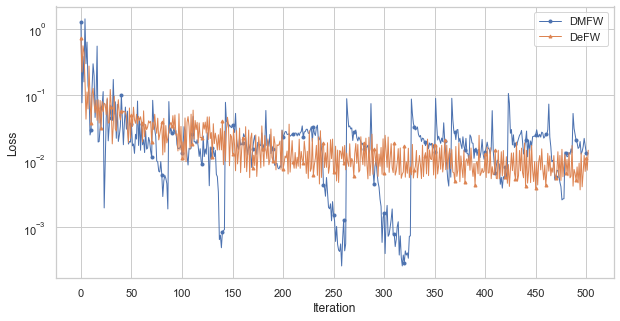

In [10]:
plotDeFW(3, "line","lux",analysis,save_path_fig,save=False,metric="loss", average=False)

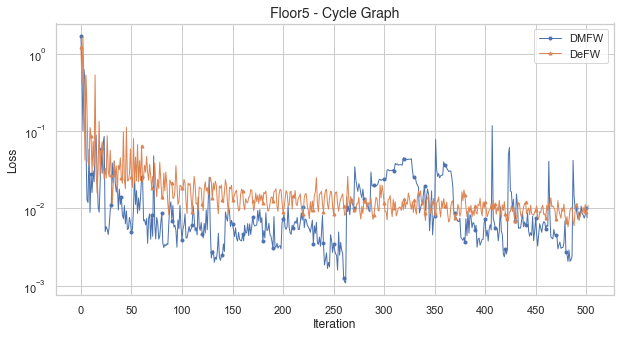

In [165]:
plotDeFW(5, "Cycle", cycle_temp,defw_cycle_temp,save_path_fig,save=False,metric="loss", average=False)